In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

df_ori = pd.read_csv('flavors_of_cacao.csv')
df = df_ori.copy()

# Naturaleza del dato

## Revisión documental

Proviene de Kaggle, creado por Rachael Tatman, pero los datos originales fueron compilados por Brady Brelinski, miembro fundador de
la Manhattan Chocolate Society, con el objetivo de registrar valoraciones expertas de barras de chocolate oscuro.
El dataset contiene calificaciones de experto de 1700 barras de chocolate individuales, junto con información sobre su origen regional, porcentaje de cacao, la variedad de grano de chocolate utilizada y dónde se cultivaron los granos, entre otras.

| Variable                                                                           | Descripción                                       |
| ---------------------------------------------------------------------------------- | ------------------------------------------------- |
| `company`                                                                          | Nombre de la empresa que produce la barra         |
| `specific_bean_origin_or_bar_name`                                                 | Región o variedad específica del grano            |
| `ref`                                                                              | Número de referencia de la empresa                |
| `review_date`                                                                      | Fecha en la cual se probó la barra                |
| `cocoa_percent`                                                                    | Porcentaje de cacao en la barra                   |
| `company_location`                                                                 | País donde la empresa está ubicada                |
| `rating`                                                                           | Valoración de la tableta de chocolate             |
| `Bean type`                                                                        | Tipo de especie de grano                          |
| `Broad bean origin`                                                                | País de origen del cacao                          |


La variable objetivo, 'Rating', contiene el siguiente sistema de clasificación:

```
5= Élite (Trasciende los límites ordinarios)
4= Premium (Desarrollo superior del sabor, carácter y estilo)
3= Satisfactorio(3.0) a loable(3.75) (bien hecho con cualidades especiales)
2= Decepcionante (Pasable pero contiene al menos un defecto significativo)
1= Desagradable (mayormente desagradable)
```

Cada chocolate se evalúa a partir de una combinación de cualidades objetivas e interpretaciones subjetivas. Una puntuación aquí sólo representa una experiencia con una tableta de un lote. Entre los valores que clasifican este rating, se encuentra el sabor, el componente más importante, se tienen en cuenta la diversidad, el equilibrio, la intensidad y la pureza de los sabores. La genética, el terruño, las técnicas posteriores a la cosecha, el procesado y el almacenamiento son factores que pueden tenerse en cuenta a la hora de considerar el componente del sabor.

La textura tiene un gran impacto en la experiencia general y también es posible que los problemas relacionados con la textura afecten al sabor. Es una buena forma de evaluar la visión del fabricante, su atención al detalle y su nivel de competencia.

El postfundido es la experiencia que se experimenta una vez fundido el chocolate. Un chocolate de calidad superior perdurará y será duradero y agradable.

En la opinión general, las puntuaciones reflejan una opinión subjetiva. 

## ¿Qué quiero hacer con la BBDD?

El objetivo principal es crear un modelo predictivo que prediga la calificación de una barra de chocolate.

Hipotesis planteadas
- 

## Clasificación del tipo de variables

```
Cualitativas:
	- Ordinales: 
	- Nominales: 'company', 'specific bean origin or bar name', 'company_location', 'Bean type', 'Broad bean origin'

Cuantitativas:
	- Discretas: 'ref', 'review_date'
	- Continuas: 'cocoa_percent', 'rating'
```

## Inspección inicial de estadísticos + tipos de datos
.info(), .describe(), .value_counts()
Identificación de errores en tipos de datos (ej. Cocoa Percent como string → convertir a numérico)


In [2]:
df = df.rename(columns={
	'Specific Bean Origin\nor Bar Name': 'specific_bean_origin',
	'Company\xa0\n(Maker-if known)': 'company',
	'REF' : 'ref',
	'Review\nDate': 'review_date',
	'Cocoa\nPercent': 'cocoa_percent',
	'Company\nLocation': 'company_location',
	'Rating': 'rating',
	'Bean\nType': 'bean_type',
	'Broad Bean\nOrigin': 'broad_bean_origin'
	})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company               1795 non-null   object 
 1   specific_bean_origin  1795 non-null   object 
 2   ref                   1795 non-null   int64  
 3   review_date           1795 non-null   int64  
 4   cocoa_percent         1795 non-null   object 
 5   company_location      1795 non-null   object 
 6   rating                1795 non-null   float64
 7   bean_type             1794 non-null   object 
 8   broad_bean_origin     1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [3]:
df.describe()

,ref,review_date,rating
count,1795.000000,1795.000000,1795.000000
mean,1035.904735,2012.325348,3.185933
std,552.886365,2.927210,0.478062
min,5.000000,2006.000000,1.000000
25%,576.000000,2010.000000,2.875000
50%,1069.000000,2013.000000,3.250000
75%,1502.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [4]:
# Corregir % de cocoa percent
df['cocoa_percent'] = df['cocoa_percent'].str.replace('%', '')

In [5]:
# Corregir specific_bean_origin
for i in range(df['specific_bean_origin'].size):
	df.loc[i, 'specific_bean_origin'] = df['specific_bean_origin'].iloc[i].split(',')[0]
	df.loc[i, 'specific_bean_origin'] = df['specific_bean_origin'].iloc[i].split('w/')[0]
		
	
# Bali (west), Sukrama Family, Melaya area
#bali (west)

In [6]:
# Corregir 'bean_type'
types = ['criollo', 'trinitario', 'forastero']
for i in range(df['bean_type'].size):
	cell = df['bean_type'].iloc[i]
	#if str(cell).strip() == '': # pd.isna(cell) or 
	if str(cell).strip() == '':
		df.loc[i, 'bean_type'] = np.nan
	else:
		value_cell = str(cell).lower()
		if value_cell == 'blend':
			df.loc[i, 'bean_type'] = 'blend'
		else:
			found = []
			for type in types:
				if type in value_cell and type not in found:
					found.append(type)
			if len(found) > 1:
				df.loc[i, 'bean_type'] = 'blend'
			elif len(found) == 1:
				df.loc[i, 'bean_type'] = found[0]
			else:
				df.loc[i, 'bean_type'] = np.nan

In [7]:
achronym_dict = {
	'dominican rep.': 'dominican republic',
	'dom. rep.': 'dominican republic',
	'domincan republic' : 'dominican republic',
	'dom. rep': 'dominican republic',
	'domin. rep': 'dominican republic',
	'd.r.': 'dominican republic',
	'dr': 'dominican republic',
	'venez': 'venezuela',
	'ven': 'venezuela',
	'ven.': 'venezuela',
	'mex': 'mexico',
	'sao tome': 'sao tome & principe',
	'principe': '',
	'trinidad, tobago': 'trinidad',
	'trinidad-tobago': 'trinidad',
	'nic.': 'nicaragua',
	'ecuad.': 'ecuador',
	'ecu.': 'ecuador',
	'mad': 'madagascar',
	'mad.': 'madagascar',
	'png': 'papua new guinea',
	'gre.': 'grenada',
	'guat': 'guatemala',
	'guat.': 'guatemala',
	'haw.': 'hawaii',
	'peru(smartin': 'peru',
	'pangoa': '',
	'nacional)': '',
	'venezuela/ ghana': 'venezuela', #'venezuela, ghana',
	'africa': '',
	'caribean': '',
	'c. am.': '',
	'cost rica': 'costa rica',
	'central and s. america': '',
	'west africa': '',
	'carribean(dr/jam/tri)': '',
	'carribean': '',
	"burma": "myanmar",
}

In [8]:
# Corregir 'Broad bean origin'

for i in range(df['broad_bean_origin'].size):
	cell = df['broad_bean_origin'].iloc[i]

	if str(cell).strip() == '':
		df.loc[i, 'broad_bean_origin'] = np.nan
	else:
		cell = str(cell).lower().strip()
		cell = cell.replace('&', ',')

		value_cell = [w.strip() for w in str(cell).split(',')]
		#value_cell = value_cell.replace(value_cell, achronym_dict)
		values_good = [achronym_dict[word] if word in achronym_dict.keys() else word for word in value_cell]
		#df.loc[i, 'broad_bean_origin'] = ", ".join(values_good).strip().strip(', ')
		df.loc[i, 'broad_bean_origin'] = values_good[0]
	
df['broad_bean_origin'] = (
	df['broad_bean_origin']
	.replace('', np.nan)
)

df['broad_bean_origin'] = (
	df['broad_bean_origin']
	.replace('nan', np.nan)
)

df['broad_bean_origin'].isna().sum()

np.int64(95)

## Corregir tipos de dato mal definidos

In [9]:
#  0   company               1795 non-null   object
df['company'] = df['company'].astype('category')
#  1   specific_bean_origin  1795 non-null   object 
df['specific_bean_origin'] = df['specific_bean_origin'].astype('category')
#  2   ref                   1795 non-null   int64  
#  3   review_date           1795 non-null   int64
#  4   cocoa_percent         1795 non-null   object
df['cocoa_percent'] = df['cocoa_percent'].astype('float64')
df['cocoa_percent'] = df['cocoa_percent'] / 100
#  5   company_location      1795 non-null   object 
df['company_location'] = df['company_location'].astype('category')
#  6   rating                1795 non-null   float64
#  7   bean_type             1794 non-null   object
df['bean_type'] = df['bean_type'].astype('category')
#  8   broad_bean_origin     1794 non-null   object 
df['broad_bean_origin'] = df['broad_bean_origin'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   company               1795 non-null   category
 1   specific_bean_origin  1795 non-null   category
 2   ref                   1795 non-null   int64   
 3   review_date           1795 non-null   int64   
 4   cocoa_percent         1795 non-null   float64 
 5   company_location      1795 non-null   category
 6   rating                1795 non-null   float64 
 7   bean_type             887 non-null    category
 8   broad_bean_origin     1700 non-null   category
dtypes: category(5), float64(2), int64(2)
memory usage: 114.5 KB


## What characteristics they ponder more for the rating of a chocolate bar?

#

In [11]:
# Whitch country have the higher 'rating' and whitch the most lowest?
country_rating = df.groupby('company_location', observed=False)['rating'].mean()

highest_country = country_rating.idxmax()
highest_rating = country_rating.max()

lowest_country = country_rating.idxmin()
lowest_rating = country_rating.min()

print(f"Country with the highest rating is: {highest_country} ({highest_rating})")
print(f"Country with the lowest rating is: {lowest_country} ({lowest_rating})")


Country with the highest rating is: Chile (3.75)
Country with the lowest rating is: India (2.5)


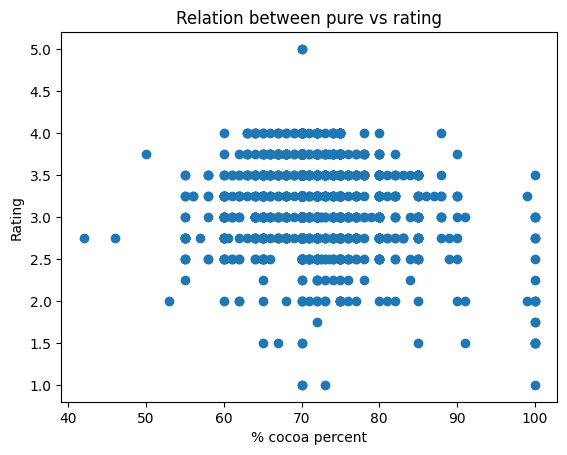

In [12]:
# If the percentage of chocolate is purer, is it better valued?

pure_rating = df.groupby('cocoa_percent')['rating'].mean()

plt.scatter(df['cocoa_percent'] * 100, df['rating'])
plt.ylabel('Rating')
plt.xlabel('% cocoa percent')
plt.title('Relation between pure vs rating')
plt.show()

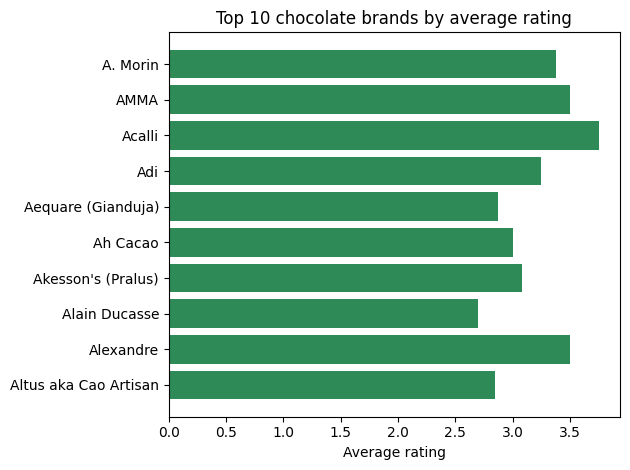

In [13]:
# que marca produce el cacao que tiene mas calidad o 'rating'

marca_df = df.groupby('company', observed=False)['rating'].mean()
plt.barh(marca_df.head(10).iloc[::-1].index, marca_df.head(10).iloc[::-1].values, color='seagreen')
plt.xlabel('Average rating')
plt.title('Top 10 chocolate brands by average rating')
plt.tight_layout()
plt.show()

In [14]:
# que grano predomina por pais
bean_type = df['bean_type'].dropna().unique()
for bean in bean_type:
	countries = df[df['bean_type'] == bean]['broad_bean_origin'].value_counts()
	if not countries.empty:
		predominant_country = countries.idxmax()
		count = countries.max()
		print(f"{bean} is the predominant bean in: {predominant_country} ({count} registros)")
	else:
		print(f"For the bean {bean}, no countries information available.")


criollo is the predominant bean in: venezuela (73 registros)
trinitario is the predominant bean in: madagascar (110 registros)
forastero is the predominant bean in: ecuador (67 registros)
blend is the predominant bean in: venezuela (13 registros)


In [15]:
# Which bean origin country has the highest rating?

# EXPLODE
# df_copy = df.copy()
# df_copy['broad_bean_origin_cleaned'] = df_copy['broad_bean_origin'].str.split(', ')
# df_exploded = df_copy.explode('broad_bean_origin_cleaned')
# df_exploded.groupby('broad_bean_origin_cleaned')['rating'].mean().sort_values(ascending=False)

# NO EXPLODE
df.groupby('broad_bean_origin', observed=False)['rating'].mean().sort_values(ascending=False)

broad_bean_origin
tobago                 3.625000
south america          3.500000
solomon islands        3.437500
haiti                  3.388889
honduras               3.350000
guatemala              3.344828
congo                  3.325000
vietnam                3.315789
papua new guinea       3.302326
brazil                 3.284483
madagascar             3.267007
venezuela              3.250000
vanuatu                3.250000
suriname               3.250000
nigeria                3.250000
australia              3.250000
malaysia               3.250000
gabon                  3.250000
cameroon               3.250000
cuba                   3.250000
belize                 3.234694
dominican republic     3.217456
hawaii                 3.214286
trinidad               3.209459
indonesia              3.205882
tanzania               3.205882
colombia               3.203488
nicaragua              3.200000
bolivia                3.197368
panama                 3.178571
sao tome & principe   

In [16]:
# What is the relationship beetwen the bean importation country and the chocolate production country

company_locations = df['company_location'].unique()
for location in company_locations:
	origin_company = df[df['company_location'] == location]['broad_bean_origin']
	count_origin = origin_company.value_counts()
	count_origin = count_origin[count_origin > 0]
	value_perc = pd.DataFrame({
		'imp_country': (count_origin.values / len(origin_company)).round(2)
	}, index=count_origin.index)
	print(f'{location.upper()}:{value_perc[:5]}\n')


FRANCE:                    imp_country
broad_bean_origin              
venezuela                  0.17
peru                       0.09
madagascar                 0.08
ecuador                    0.06
dominican republic         0.05

U.S.A.:                    imp_country
broad_bean_origin              
dominican republic         0.15
peru                       0.11
venezuela                  0.10
ecuador                    0.10
madagascar                 0.07

FIJI:                   imp_country
broad_bean_origin             
fiji                       1.0

ECUADOR:                   imp_country
broad_bean_origin             
ecuador                   0.96
colombia                  0.02
peru                      0.02

MEXICO:                   imp_country
broad_bean_origin             
mexico                     1.0

SWITZERLAND:                   imp_country
broad_bean_origin             
venezuela                 0.42
bolivia                   0.11
madagascar                0.08
ecuad

In [17]:
# Whats the mean purity of the cacao in each country?

df.groupby('company_location', observed=False)['cocoa_percent'].mean().sort_values(ascending=False).head(10)


company_location
Sao Tome       0.821250
Ghana          0.800000
Ireland        0.785000
Portugal       0.760000
Fiji           0.750000
Honduras       0.750000
Vietnam        0.745455
U.K.           0.743113
New Zealand    0.734118
Argentina      0.733333
Name: cocoa_percent, dtype: float64

In [18]:
# clustering 'company_location'

continent_dict = {
	'north_america': [
		'u.s.a.', 'canada', 'mexico', 'puerto rico', 'hawaii'
	],
	'central_america': [
		'guatemala', 'costa rica', 'nicaragua', 'honduras',
		'belize', 'panama', 'el salvador'
	],
	'south_america': [
		'ecuador', 'colombia', 'venezuela', 'brazil', 'peru',
		'argentina', 'bolivia', 'chile', 'suriname', 'south america'
	],
	'europe_west': [
		'france', 'u.k.', 'italy', 'belgium', 'switzerland', 'germany',
		'austria', 'spain', 'denmark', 'netherlands', 'ireland',
		'portugal', 'iceland', 'sweden', 'finland'
	],
	'europe_east': [
		'hungary', 'poland', 'lithuania', 'czech republic', 'russia'
	],
	'africa': [
		'madagascar', 'sao tome', 'sao tome & principe', 'ghana', 'south africa',
		'tanzania', 'congo', 'uganda', 'ivory coast', 'togo',
		'liberia', 'nigeria', 'gabon', 'cameroon'
	],
	'asia': [
		'japan', 'vietnam', 'israel', 'south korea', 'india', 'philippines',
		'singapore', 'indonesia', 'myanmar', 'sri lanka', 'malaysia'
	],
	'oceania': [
		'australia', 'new zealand', 'fiji', 'vanuatu', 'solomon islands',
		'samoa', 'papua new guinea'
	],
	'caribbean': [
		'dominican republic', 'grenada', 'st. lucia', 'martinique', 'jamaica',
		'trinidad', 'tobago', 'cuba', 'haiti'
	]
}

country_to_continent = {}
for continent, countries in continent_dict.items():
	for country in countries:
		country_to_continent[country] = continent

df['company_location'] = df['company_location'].str.lower()

df['region_impor'] = df['company_location'].map(country_to_continent)

df['region_expor'] = df['broad_bean_origin'].map(country_to_continent)

df['region_expor'].value_counts()

region_expor
south_america      756
caribbean          277
africa             267
central_america    201
asia                70
oceania             67
north_america       62
Name: count, dtype: int64

In [19]:
categoricas = ['company', 'specific_bean_origin', 'company_location', 'bean_type', 'broad_bean_origin', 'region_impor', 'region_expor']
cuantitativas = ['ref', 'review_date', 'cocoa_percent', 'rating']


df_categoricas = df[categoricas]
df_cuantitativas = df[cuantitativas]
y = 'rating'

In [20]:
def chi2(feat1, feat2):
	df_copy = df.copy()
	df_copy = df_copy.dropna(subset=[feat1, feat2])
	contingencia = pd.crosstab(df_copy[feat1] , df_copy[feat2])
	chi2 , p_value , _ , _ = chi2_contingency(contingencia)
	if p_value < 0.05:
		print(f"Las cualitativas {feat1} y {feat2} tienen dependencia")
	else: 
		print(f"Las cualitativas {feat1} y {feat2} NO tienen dependencia")

def chi2_ret_pvalue(feat1, feat2):
	df_copy = df.copy()
	df_copy = df_copy.dropna(subset=[feat1, feat2])
	contingencia = pd.crosstab(df_copy[feat1] , df_copy[feat2])
	chi2 , p_value , _ , _ = chi2_contingency(contingencia)
	return round(p_value, 3)

<Axes: >

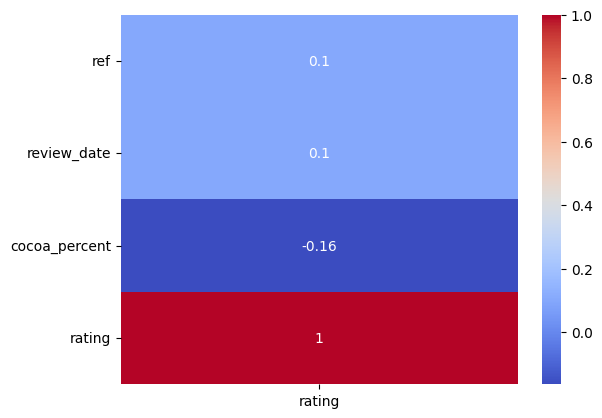

In [21]:
# Cuantitativas vs Objetivo (cuantitativa)
corr_rating = df_cuantitativas.corr()[['rating']]

sns.heatmap(data=corr_rating, annot=True, cmap='coolwarm')

In [22]:
def anova_test(num_feat, cat_feat):
	df_filtered = df.dropna(subset=[cat_feat, num_feat])
	grupos = [df_filtered[df_filtered[cat_feat] == cat][num_feat] for cat in df_filtered[cat_feat].unique()]
	if len(grupos) > 2:
		if all(g.nunique() <= 1 for g in grupos):
			print(f"var={cat_feat} // Todos los grupos tienen valores constantes. ANOVA no es aplicable.")
			return
		stat, p = stats.f_oneway(*grupos)
		return p
	else:
		print("La variable categórica tiene 2 o menos categorías, usa t-test.")

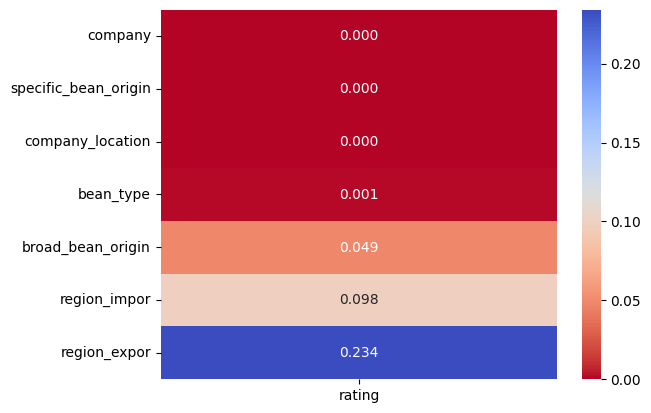

In [23]:
# Cualitativas vs Objectivo (cuantitativa)
df_map = pd.DataFrame({y: [anova_test(y, x) for x in categoricas]}, index=categoricas)
sns.heatmap(data=df_map, annot=True, cmap='coolwarm_r', fmt='.3f')
plt.show()

{'company': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'specific_bean_origin': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'company_location': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'bean_type': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'broad_bean_origin': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'region_impor': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'region_expor': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]}


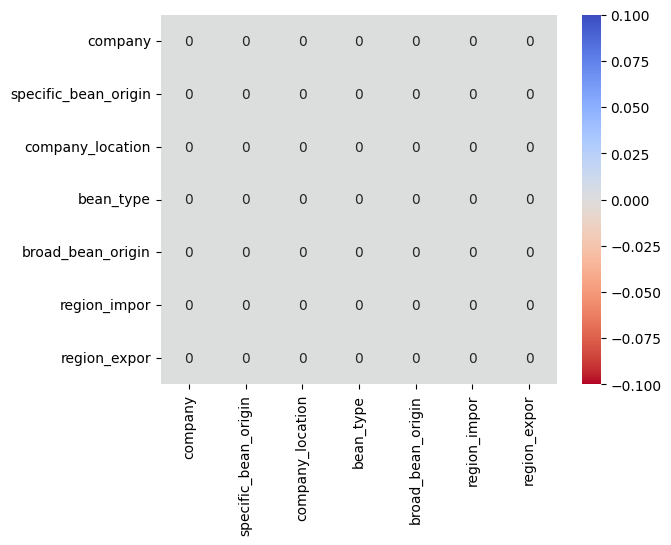

In [24]:
# categoricas vs categoricas
dic = {}

for cat in categoricas:
	dic[cat] = [chi2_ret_pvalue(cat, j) for j in categoricas]
	
print(dic)

df_test = pd.DataFrame(dic, index=categoricas)
sns.heatmap(data=df_test, annot=True, cmap='coolwarm_r')
plt.show()

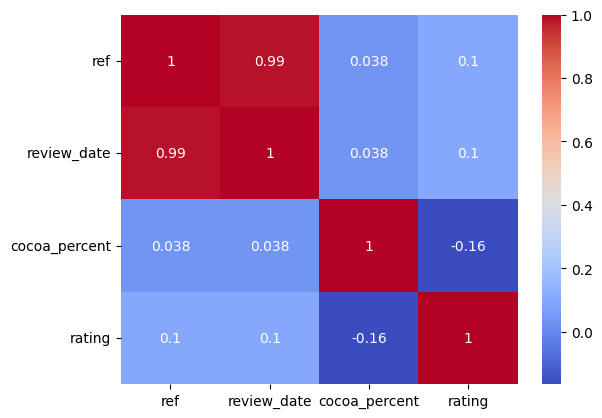

In [25]:
# cuantitativas vs cuantitativas

sns.heatmap(data=df_cuantitativas.corr(), annot=True, cmap='coolwarm')
plt.show()


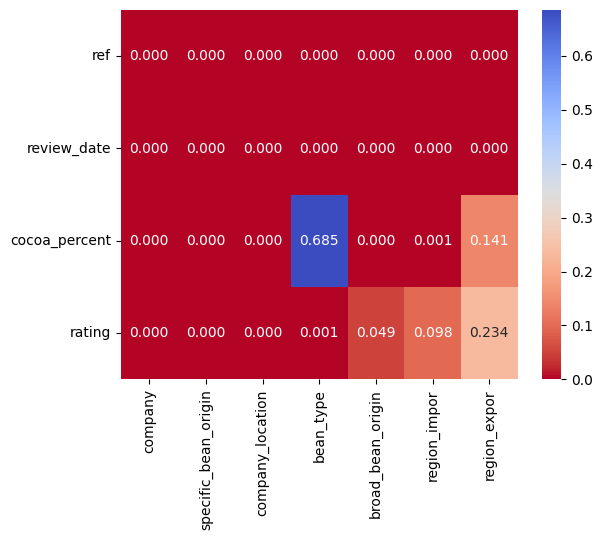

In [26]:
# categóricas vs cuantitativas

dic = {}

for x in categoricas:
	dic[x] = [anova_test(y, x) for y in cuantitativas]

df_test = pd.DataFrame(dic, index=cuantitativas)
sns.heatmap(data=df_test, annot=True, cmap='coolwarm_r', fmt=".3f")
plt.show()

In [27]:
Y = df[['rating']]
X = df[['company', 'review_date', 'cocoa_percent', 'company_location', 'bean_type', 'broad_bean_origin']]

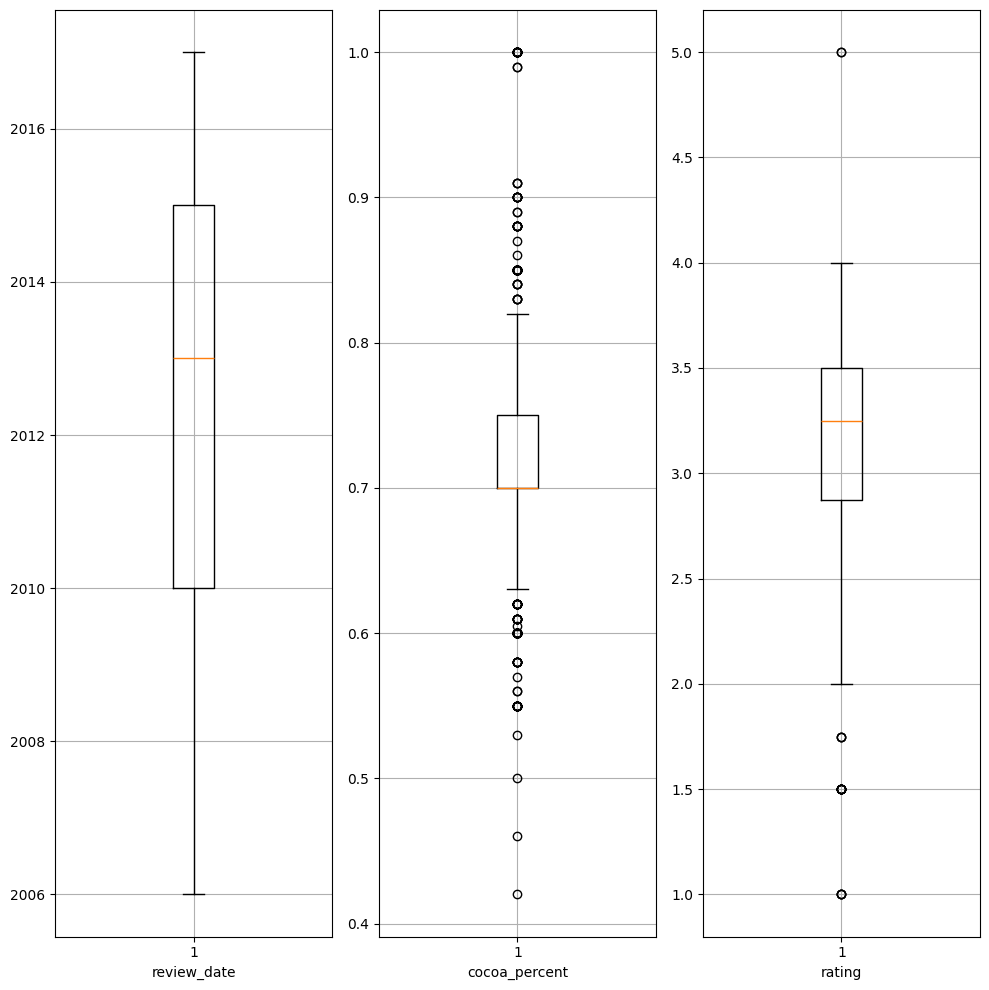

In [28]:
num_features = 3
data = df[['review_date', 'cocoa_percent', 'rating']]
fig, axes = plt.subplots(1, num_features, figsize=(10, 10))

for i in range(num_features):
	ax = axes[i]
	ax.boxplot(data.iloc[:,i])
	ax.set_xlabel(data.columns[i], fontsize=10)
	ax.grid()
plt.tight_layout()
plt.show()

In [29]:
# Outliers cocoa_percent
lower_quan = df['cocoa_percent'].quantile(0.05)
upper_quan = df['cocoa_percent'].quantile(0.95)


df['cocoa_percent_wins'] = df['cocoa_percent'].clip(lower=lower_quan, upper=upper_quan)

In [30]:
# Outliers rating
lower_quan = df['rating'].quantile(0.05)
upper_quan = df['rating'].quantile(0.95)


df['rating_wins'] = df['rating'].clip(lower=lower_quan, upper=upper_quan)

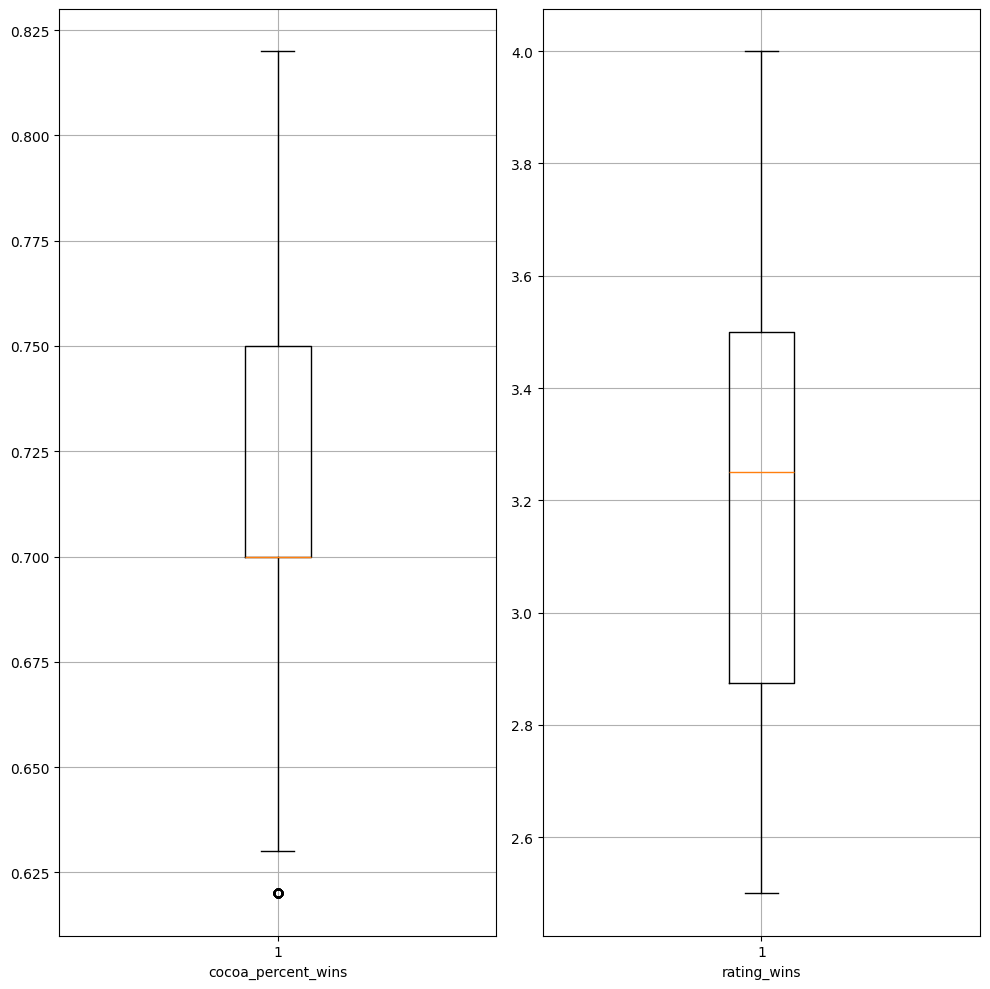

In [31]:
num_features = 2
data = df[['cocoa_percent_wins', 'rating_wins']]
fig, axes = plt.subplots(1, num_features, figsize=(10, 10))

for i in range(num_features):
	ax = axes[i]
	ax.boxplot(data.iloc[:,i])
	ax.set_xlabel(data.columns[i], fontsize=10)
	ax.grid()
plt.tight_layout()
plt.show()

In [32]:
# MISSINGS

nulls = df.isnull().sum()
nulls

company                   0
specific_bean_origin      0
ref                       0
review_date               0
cocoa_percent             0
company_location          0
rating                    0
bean_type               908
broad_bean_origin        95
region_impor              0
region_expor             95
cocoa_percent_wins        0
rating_wins               0
dtype: int64

In [33]:
perc_col = nulls['bean_type'] / X['bean_type'].size * 100
perc_all = nulls['bean_type'] / df.size * 100
perc_all

np.float64(3.891150632097707)

In [34]:
print(df['company'].value_counts().to_string())

company
Soma                                       47
Bonnat                                     27
Fresco                                     26
Pralus                                     25
A. Morin                                   23
Domori                                     22
Arete                                      22
Guittard                                   22
Valrhona                                   21
Hotel Chocolat (Coppeneur)                 19
Mast Brothers                              18
Coppeneur                                  18
Zotter                                     17
Scharffen Berger                           17
Rogue                                      16
Artisan du Chocolat                        16
Dandelion                                  16
Smooth Chocolator, The                     16
Szanto Tibor                               15
Tejas                                      14
Bittersweet Origins                        14
Castronovo                

['rating_wins', 'review_date', 'region_impor', 'region_expor']


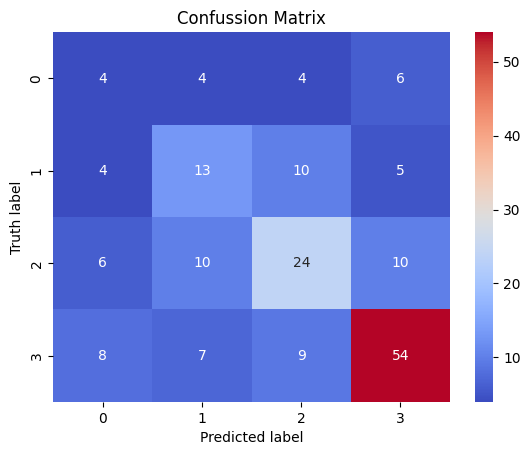

              precision    recall  f1-score   support

       blend       0.18      0.22      0.20        18
     criollo       0.38      0.41      0.39        32
   forastero       0.51      0.48      0.49        50
  trinitario       0.72      0.69      0.71        78

    accuracy                           0.53       178
   macro avg       0.45      0.45      0.45       178
weighted avg       0.55      0.53      0.54       178



In [35]:
# Regresion logistica bean type

df_model = df.copy()

num_features = ['rating_wins', 'review_date']
cat_features = ['region_impor', 'region_expor']

print(num_features + cat_features)

#df_model = df_model[num_features + cat_features].dropna()
df_model = df_model[num_features + cat_features + ['bean_type']]
df_model = df_model[df_model['bean_type'].notna()]

x_df_model = df_model.drop(columns='bean_type')
y_df_model = df_model['bean_type']

# Codificador
preprocessor = ColumnTransformer(transformers=[
	('cat', OneHotEncoder(drop='first'), cat_features)
], remainder='passthrough')


# podria subir algo mas al usar target encoder con cpmpany

# Pipeline
pipeline = Pipeline(steps=[
	('preprocessor', preprocessor),
	('classifier', RandomForestClassifier(class_weight='balanced'))
	#('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
X_train , X_test , y_train , y_test = train_test_split(x_df_model , y_df_model , test_size=0.2)
pipeline.fit(X_train , y_train)

y_pred = pipeline.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm')
plt.title('Confussion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Truth label')
plt.show()
print(metrics.classification_report(y_test, y_pred))

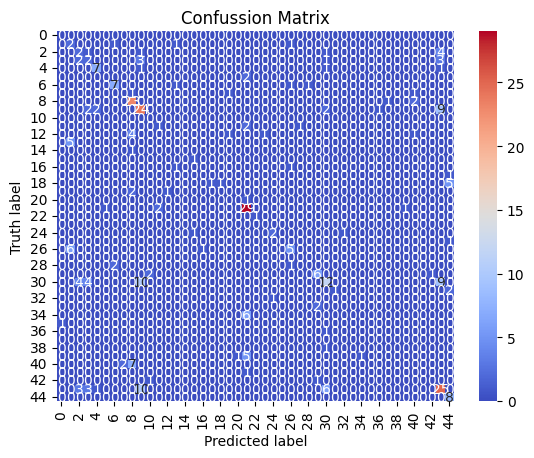

                     precision    recall  f1-score   support

          australia       0.00      0.00      0.00         0
             belize       0.15      0.40      0.22         5
            bolivia       0.18      0.22      0.20         9
             brazil       0.17      0.18      0.17        11
           colombia       0.70      0.70      0.70        10
              congo       0.00      0.00      0.00         2
         costa rica       0.70      0.70      0.70        10
               cuba       0.00      0.00      0.00         3
 dominican republic       0.61      0.88      0.72        26
            ecuador       0.49      0.60      0.54        40
               fiji       0.00      0.00      0.00         0
              ghana       0.33      0.25      0.29         4
            grenada       0.00      0.00      0.00         7
          guatemala       0.00      0.00      0.00         5
              haiti       0.00      0.00      0.00         1
             hawaii    

In [36]:
# Regression logistica Broad bean origin

df_model = df.copy()

num_features = ['rating_wins', 'review_date', 'cocoa_percent_wins']
cat_features = ['region_impor', 'region_expor']
target_encoded_features = ['company']

#df_model = df_model[num_features + cat_features].dropna()
df_model = df_model[num_features + cat_features + target_encoded_features + ['broad_bean_origin']]
df_model = df_model[df_model['broad_bean_origin'].notna()]

x_df_model = df_model.drop(columns='broad_bean_origin')
y_df_model = df_model['broad_bean_origin']

# # Codificador
# preprocessor = ColumnTransformer(transformers=[
#     ('cat', OneHotEncoder(drop='first'), cat_features)
# ], remainder='passthrough')

preprocessor = ColumnTransformer(transformers=[
	('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
	('target', TargetEncoder(), target_encoded_features)
], remainder='passthrough')

# Pipeline
pipeline = Pipeline(steps=[
	('preprocessor', preprocessor),
	('classifier', RandomForestClassifier(class_weight='balanced'))
	#('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])
X_train , X_test , y_train , y_test = train_test_split(x_df_model , y_df_model , test_size=0.2)
pipeline.fit(X_train , y_train)

y_pred = pipeline.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm')
plt.title('Confussion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Truth label')
plt.show()
print(metrics.classification_report(y_test, y_pred))

In [37]:
perc_all = nulls['broad_bean_origin'] / df.size * 100

# lineal, solo es un 5 %
perc_col = nulls['broad_bean_origin'] / X['broad_bean_origin'].size * 100
perc_col

np.float64(5.2924791086350975)

In [38]:
df_rfe = df.copy()
df_rfe['company_encoded'] = LabelEncoder().fit_transform(df_rfe['company'].astype(str))
df_rfe['company_location_encoded'] = LabelEncoder().fit_transform(df_rfe['company_location'].astype(str))
df_rfe['region_impor_encoded'] = LabelEncoder().fit_transform(df_rfe['region_impor'].astype(str))
df_rfe['region_expor_encoded'] = LabelEncoder().fit_transform(df_rfe['region_expor'].astype(str))

'region_impor', 'region_expor'


# Selecciona las variables para RFE (incluyendo la codificada)
categoricas_rfe = ['company_encoded', 'specific_bean_origin', 'company_location_encoded', 'bean_type', 'broad_bean_origin', 'region_impor_encoded', 'region_expor_encoded']
x_rfe = df_rfe[categoricas_rfe].apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)
y_rfe = df_rfe['rating']

reg = linear_model.LinearRegression()
selector = RFE(estimator=reg, n_features_to_select=3)
selector.fit(x_rfe, y_rfe)
print(x_rfe.columns[selector.support_].values)

['company_location_encoded' 'bean_type' 'region_impor_encoded']


In [39]:
cols = df.columns
cols

no_seleccionadas_final = [ 'cocoa_percent', 'company_location', 'bean_type', 'broad_bean_origin']
x_rfe_sel = df[['company', 'specific_bean_origin', 'ref', 'review_date',
		'region_impor', 'region_expor']].copy()

for col in x_rfe_sel.select_dtypes(include=['category', 'object']).columns:
	x_rfe_sel[col] = x_rfe_sel[col].astype('category').cat.codes

y_rfe_sel = df[['rating']]

X2 = sm.add_constant(x_rfe_sel)
est = sm.OLS(y_rfe_sel, X2)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.918
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           0.000678
Time:                        12:43:13   Log-Likelihood:                -1210.0
No. Observations:                1795   AIC:                             2434.
Df Residuals:                    1788   BIC:                             2473.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.6184 

In [ ]:
y = df[['rating_wins']]

x_own_cat = ['bean_type', 'region_impor', 'region_expor', 'company']#'broad_bean_origin', 'company_location'] #
x_own_num = ['review_date', 'cocoa_percent_wins']

print(df[x_own_cat].isna().sum())

x_own_all = df[x_own_cat + x_own_num]
#all_cat = [e for inner_list in all_cat for e in inner_list]
# all_cats = df[x_own_cat].value_counts()

# indexes = all_cats.keys().to_list()
# print(indexes)

cat_pipe = Pipeline(steps=[
	('imputer', SimpleImputer(strategy='most_frequent')),
	('onehot', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

num_pipe = Pipeline(steps=[
	('scalar', StandardScaler(with_mean=False)),
])

preprocessor = ColumnTransformer(transformers=[
	('cat', cat_pipe, x_own_cat),
	('num', num_pipe, x_own_num)
], remainder='passthrough')


pipeline = Pipeline(steps=[
	('preprocessor', preprocessor),
	('linear', linear_model.LinearRegression())
])

x_train, x_test, y_train, y_test = train_test_split(x_own_all, y, test_size=0.2, random_state=56) # 56
pipeline.fit(x_train, y_train)

# evaluación del modelo
y_pred = pipeline.predict(x_test)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r_squared = metrics.r2_score(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('True rating')
plt.ylabel('Predicted rating')
plt.title('Predicción de rating (regresión lineal)')
plt.show()

print(f'Linear Regression - MAE: {mae:.2f} | MSE: {mse:.2f} | R2: {r_squared:.2f}')

# from sklearn.ensemble import RandomForestRegressor

# pipeline_rf = Pipeline(steps=[
# 	('preprocessor', preprocessor),
# 	('rf', RandomForestRegressor(n_estimators=100, random_state=56))
# ])

# pipeline_rf.fit(x_train, y_train.values.ravel())
# y_pred_rf = pipeline_rf.predict(x_test)

# mae_rf = metrics.mean_absolute_error(y_test, y_pred_rf)
# mse_rf = metrics.mean_squared_error(y_test, y_pred_rf)
# r2_rf = metrics.r2_score(y_test, y_pred_rf)

# print(f'Random Forest - MAE: {mae_rf:.2f} | MSE: {mse_rf:.2f} | R2: {r2_rf:.2f}')

# from sklearn.ensemble import GradientBoostingRegressor

# pipeline_gb = Pipeline(steps=[
# 	('preprocessor', preprocessor),
# 	('gb', GradientBoostingRegressor(n_estimators=100, random_state=56))
# ])

# pipeline_gb.fit(x_train, y_train.values.ravel())
# y_pred_gb = pipeline_gb.predict(x_test)

# mae_gb = metrics.mean_absolute_error(y_test, y_pred_gb)
# mse_gb = metrics.mean_squared_error(y_test, y_pred_gb)
# r2_gb = metrics.r2_score(y_test, y_pred_gb)

# print(f'Gradient Boosting - MAE: {mae_gb:.2f} | MSE: {mse_gb:.2f} | R2: {r2_gb:.2f}')

Regresion lineal: {'regressor__fit_intercept': True}
Random_forest : {'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}
Gradient Boosting Regressor: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}

Lr (optimizado) (Validacion Cruzada en Entrenamiento) : 
MSE (mean ± std): 0.1647 ± 0.0105
R² (mean ± std): 0.0688 ± 0.0539
R² ajustado (mean ± std): -0.2974 ± 0.0751

Lr (optimizado) (Conjunto prueba) : 
MSE: 0.1571
R²: 0.1699
R² ajustado: 0.1557

RF (optimizado) (Validacion Cruzada en Entrenamiento) : 
MSE (mean ± std): 0.1435 ± 0.0060
R² (mean ± std): 0.1878 ± 0.0434
R² ajustado (mean ± std): -0.1316 ± 0.0605

RF (optimizado) (Conjunto prueba) : 
MSE: 0.1443
R²: 0.2378
R² ajustado: 0.2248

GB R (optimizado) (Validacion Cruzada en Entrenamiento) : 
MSE (mean ± std): 0.1452 ± 0.0043
R² (mean ± std): 0.1789 ± 0.0282
R² ajustado (mean ± std): -0.1440 ± 0.0392

GB R (optimizado) (Conjunto prueba) : 
MS

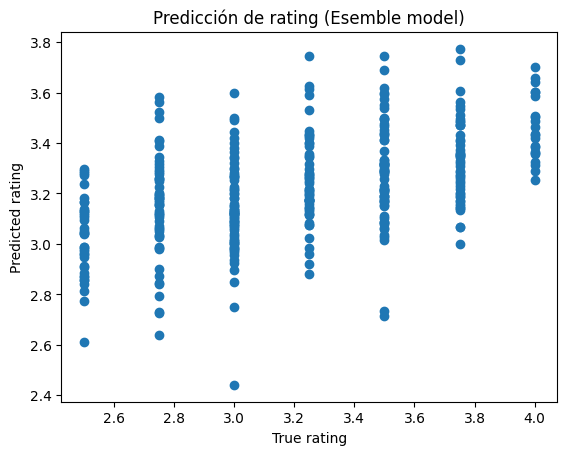


Ensamblado (RL + RF + GBR + NN) (Conjunto prueba) : 
MSE: 0.1408
R²: 0.2559
R² ajustado: 0.2433


In [44]:
# ensemble

Y = df[['rating_wins']]

X_cat = ['bean_type', 'region_impor', 'region_expor', 'company']#'broad_bean_origin', 'company_location'] #
X_num= ['review_date', 'cocoa_percent_wins']

cat_pipe = Pipeline([
	('imputer', SimpleImputer(strategy='most_frequent')),
	('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

num_pipe = Pipeline([
	('imputer', SimpleImputer(strategy='mean')),
	('scaler', RobustScaler())
])

preprocessor = ColumnTransformer([
	('cat', cat_pipe, X_cat),
	('num', num_pipe, X_num)
])

X_train, X_test, y_train, y_test = train_test_split(
	df[X_cat + X_num], Y, test_size=0.2, random_state=56
)

kfold = KFold(n_splits=5, shuffle=True, random_state=56)

lr = linear_model.LinearRegression()
rf = RandomForestRegressor(random_state=56)
gb = GradientBoostingRegressor(random_state=56)

pipe_lr = Pipeline([('preprocessor', preprocessor), ('regressor', lr)])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', rf)])
pipe_gb = Pipeline([('preprocessor', preprocessor), ('regressor', gb)])

param_grid_lr = {
	'regressor__fit_intercept': [True, False]
}
param_grid_rf ={
	'regressor__n_estimators': [100, 200, 300],
	'regressor__max_depth': [None, 10, 20, 30],
	'regressor__min_samples_split': [2, 5, 10]
}

param_grid_gb = {
	'regressor__n_estimators': [100, 200, 300],
	'regressor__learning_rate': [0.001, 0.01, 0.1, 0.2],
	'regressor__max_depth': [3, 5, 7]
}


grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_gb = GridSearchCV(pipe_gb, param_grid_gb, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)

grid_lr.fit(X_train,y_train)
grid_rf.fit(X_train,y_train)
grid_gb.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_


print(f"Regresion lineal: {grid_lr.best_params_}")
print(f"Random_forest : {grid_rf.best_params_}")
print(f"Gradient Boosting Regressor: {grid_gb.best_params_}")


esemble = VotingRegressor(
	estimators=[
		('lr', best_lr),
		('rf', best_rf),
		('gb', best_gb)
	]
)

def evaluar_modelo(model , X_train , y_train , X_test, y_test , model_name , use_scale = False):
	def adjusted_r2_score(y_true , y_pred , n_features):
		r2 = metrics.r2_score(y_true , y_pred)
		n = len(y_true)
		adj_r2 = 1 - (1-r2) * (n-1) / (n - n_features -1)
		return adj_r2

	mse_scores = -cross_val_score(model , X_train , y_train , cv = kfold , scoring='neg_mean_squared_error')
	r2_scores = cross_val_score(model , X_train , y_train , cv = kfold , scoring='r2')

	if (model == esemble):
		X_train_transformed = preprocessor.fit_transform(X_train)
		p = X_train_transformed.shape[1]
	else:
		model_temp = model
		model_temp.fit(X_train, y_train)
		X_train_transformed = model_temp.named_steps['preprocessor'].transform(X_train)
		p = X_train_transformed.shape[1] # vars


	n = X_train.shape[0] # len
	adj_r2_scores = [1 - (1-r2) * (n-1) / (n-p-1) for r2 in r2_scores]

	print(f"\n{model_name} (Validacion Cruzada en Entrenamiento) : ")
	print(f"MSE (mean ± std): {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
	print(f"R² (mean ± std): {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
	print(f"R² ajustado (mean ± std): {np.mean(adj_r2_scores):.4f} ± {np.std(adj_r2_scores):.4f}")

	model.fit(X_train , y_train)
	y_pred = model.predict(X_test)
	mse_test = metrics.mean_squared_error(y_test , y_pred)
	r2_test = metrics.r2_score(y_test , y_pred)
	adj_r2_test = adjusted_r2_score(y_test , y_pred , X_train.shape[1])

	if (model == esemble):
		plt.scatter(y_test, y_pred)
		plt.xlabel('True rating')
		plt.ylabel('Predicted rating')
		plt.title('Predicción de rating (Esemble model)')
		plt.show()


	print(f"\n{model_name} (Conjunto prueba) : ")
	print(f"MSE: {mse_test:.4f}")
	print(f"R²: {r2_test:.4f}")
	print(f"R² ajustado: {adj_r2_test:.4f}")

evaluar_modelo(best_lr, X_train, y_train, X_test, y_test, 'Lr (optimizado)')
evaluar_modelo(best_rf, X_train, y_train, X_test, y_test, 'RF (optimizado)')
evaluar_modelo(best_gb, X_train, y_train, X_test, y_test, 'GB R (optimizado)')

evaluar_modelo(esemble, X_train, y_train, X_test, y_test, 'Ensamblado (RL + RF + GBR + NN)')

